In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)
    
np.set_printoptions(precision=4, suppress=True)

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [8]:
from codeE.representation import set_representation
from codeE.generate_data import SyntheticData
from codeE.methods import *
from codeE.evaluation import accuracy_model
import keras,gc, time, sys, os

import matplotlib
font = {'family' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=25)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=25)    # fontsize of the x and y labels
ms = 15 #markersize
lw = 4

In [3]:
folder = "./data/synthetic/"

X_train = np.loadtxt(folder+"/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/datasim_Z_train.csv",dtype='int') 

X_test = np.loadtxt(folder+"/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/datasim_Z_test.csv",dtype='int') 

print("Input shape:",X_train.shape)

from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=True) 
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)

Input shape: (2457, 2)


In [4]:
to_check = [100,2000,5000,10000,15000,25000,40000] #otras opciones
T_data = 5 #fixed annotations per data

## Memory Consumption
memory in MB

In [5]:
to_mb = 1./(1024*1024)

N = Xstd_train.shape[0]
K = 10

### Data Representation
annotations representation

100
2000
5000
10000
15000
25000
40000


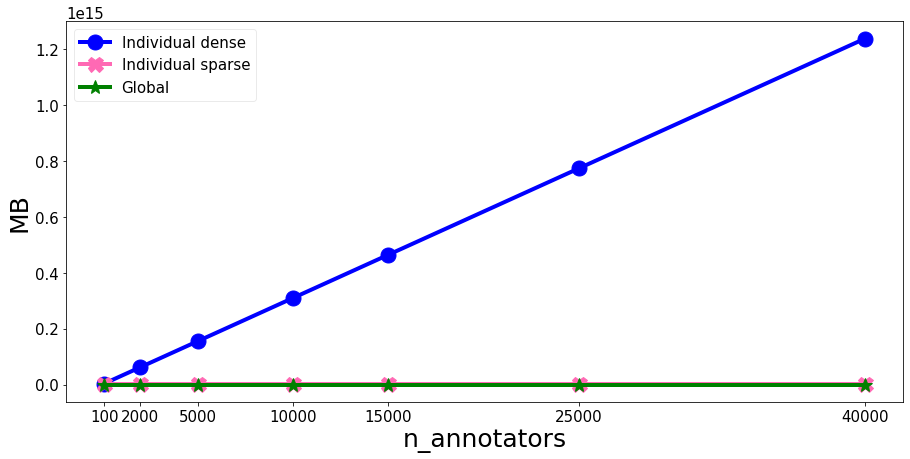

In [29]:
M_individual_dense = []
M_individual_sparse = []
M_global = []

for t in to_check:
    print(t)
    y_ann = np.zeros((N,t,K),dtype='float32')
    M_individual_dense.append(y_ann.nbytes/to_mb) #MB
    gc.collect()

M_global = np.zeros((N,K),dtype='float32').nbytes/to_mb

M_individual_sparse = np.zeros((N,T_data,K),dtype='float32').nbytes/to_mb #annotations
M_individual_sparse += np.zeros((N,T_data),dtype='float32').nbytes/to_mb #identity

plt.figure(figsize=(15,7))
plt.plot(to_check, M_individual_dense,'bo-',label="Individual dense", markersize=ms,linewidth=lw)
plt.plot(to_check, np.tile(M_individual_sparse,len(to_check)),'X-',label="Individual sparse",color='hotpink', markersize=ms,linewidth=lw)
plt.plot(to_check, np.tile(M_global,len(to_check)),'g*-',label="Global", markersize=ms,linewidth=lw)

plt.xticks(to_check)
plt.ylabel("MB")
plt.xlabel("n_annotators")
plt.legend(loc='upper left', fancybox=True, framealpha=0.4)
plt.show()

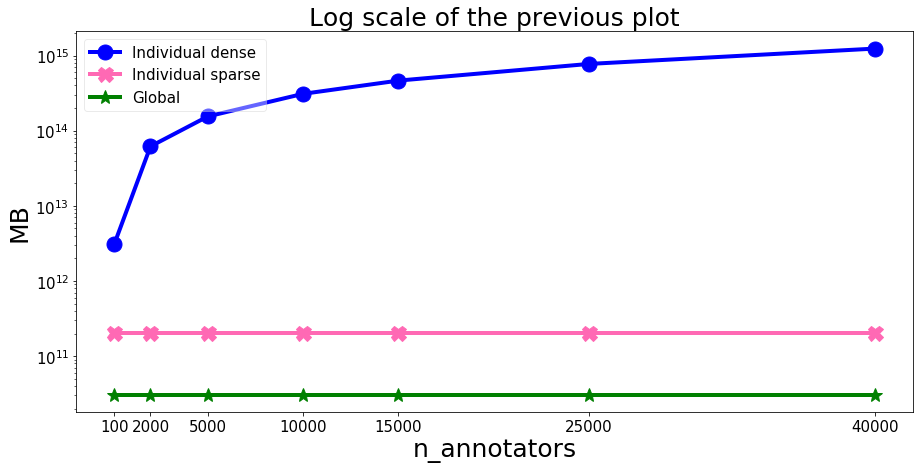

In [30]:
plt.figure(figsize=(15,7))
plt.plot(to_check, M_individual_dense,'bo-',label="Individual dense", markersize=ms,linewidth=lw)
plt.plot(to_check, np.tile(M_individual_sparse,len(to_check)),'X-',label="Individual sparse",color='hotpink', markersize=ms,linewidth=lw)
plt.plot(to_check, np.tile(M_global,len(to_check)),'g*-',label="Global", markersize=ms,linewidth=lw)

plt.xticks(to_check)
plt.ylabel("MB")
plt.xlabel("n_annotators")
plt.legend(loc='upper left', fancybox=True, framealpha=0.4)
plt.title("Log scale of the previous plot")
plt.yscale('log')
plt.show()

The summary of the methods scenario/representation could be seen in [Comparison](./docs/comparison.md)


#### What about the annotator representation for the individual sparse model
> Assuming a K-dimensional vector for every annotator

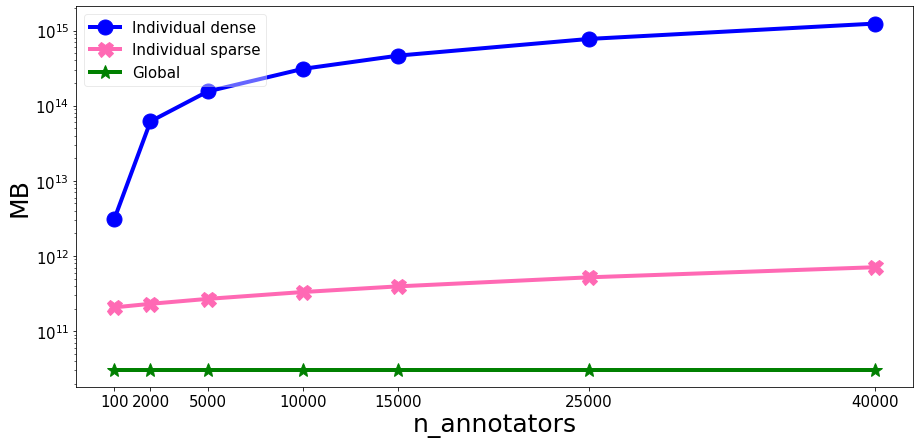

In [22]:
M_individual_sparse = np.tile(M_individual_sparse,len(to_check))

for i, t in enumerate(to_check):
    ann_id = np.zeros((t,K),dtype='float32') #ann representation: A_t
    M_individual_sparse[i] += ann_id.nbytes/to_mb    
    gc.collect()

plt.figure(figsize=(15,7))
plt.plot(to_check, M_individual_dense,'bo-',label="Individual dense", markersize=ms,linewidth=lw)
plt.plot(to_check, M_individual_sparse,'X-',label="Individual sparse",color='hotpink', markersize=ms,linewidth=lw)
plt.plot(to_check, np.tile(M_global,len(to_check)),'g*-',label="Global", markersize=ms,linewidth=lw)

plt.xticks(to_check)
plt.ylabel("MB")
plt.xlabel("n_annotators")
plt.legend(loc='upper left', fancybox=True, framealpha=0.4)
plt.yscale('log')
plt.show()

### Parameters consume (modeled)
Without the parameters of the predictive model

100
2000
5000
10000
15000
25000
40000


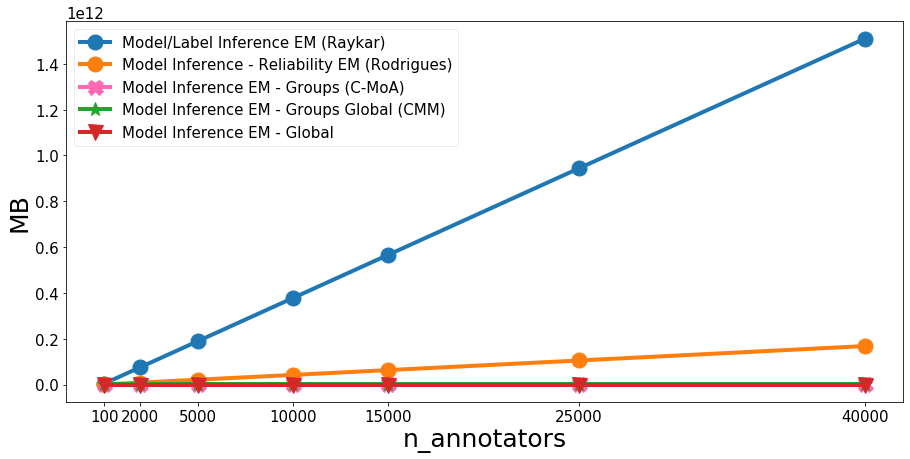

In [31]:
C_ds = []
C_raykar = []
C_cmm = []
C_cmoa = []
C_global = []
C_re = []

M = 3
for t in to_check:
    print(t)
    betas = np.zeros((t,K,K),dtype='float32') #conf matrix - p(y|z)
    C_raykar.append(betas.nbytes/to_mb)

    reliability_param = np.zeros((t,1),dtype='float32')
    C_re.append(reliability_param.nbytes/to_mb)

    gc.collect()

C_global = np.zeros((K,K),dtype='float32').nbytes/to_mb #one confusion matrix

betas_per_group = np.zeros((M,K,K),dtype='float32')

C_cmm  = betas_per_group.nbytes/to_mb #conf matrix per group
C_cmm += np.zeros((M),dtype='float32').nbytes/to_mb # mixing coef - p(g)

C_cmoa  = betas_per_group.nbytes/to_mb #conf matrix per group
C_cmoa += np.zeros((M,K,K+M),dtype='float32').nbytes/to_mb #p(g|a) - group assignment

plt.figure(figsize=(15,7))
plt.plot(to_check, C_raykar,'o-',label="Model/Label Inference EM (Raykar)", markersize=ms,linewidth=lw)
plt.plot(to_check, C_re,'o-',label="Model Inference - Reliability EM (Rodrigues)", markersize=ms,linewidth=lw)

plt.plot(to_check, np.tile(C_cmoa,len(to_check)),'X-',label="Model Inference EM - Groups (C-MoA)",color='hotpink', markersize=ms,linewidth=lw)
plt.plot(to_check, np.tile(C_cmm,len(to_check)),'*-',label="Model Inference EM - Groups Global (CMM)", markersize=ms,linewidth=lw)
plt.plot(to_check, np.tile(C_global,len(to_check)),'v-',label="Model Inference EM - Global", markersize=ms,linewidth=lw)

plt.xticks(to_check)
plt.ylabel("MB")
plt.xlabel("n_annotators")
plt.legend(loc='upper left', fancybox=True, framealpha=0.4)
#plt.yscale('log')
plt.show()

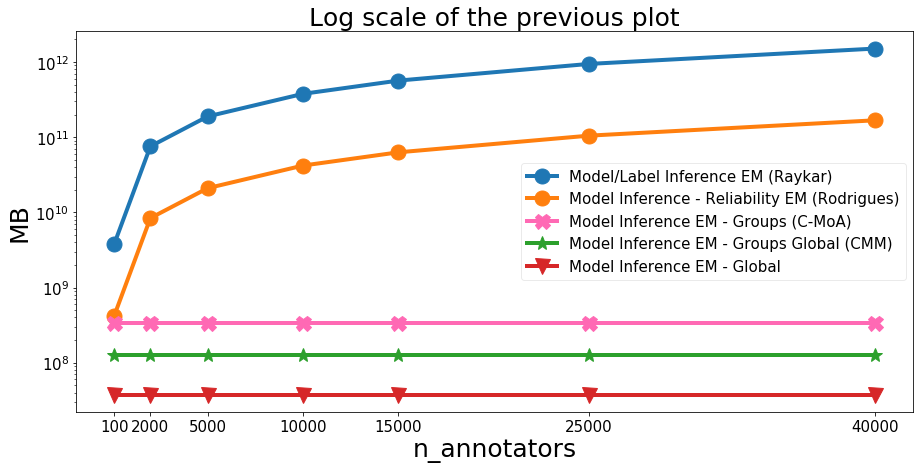

In [32]:
plt.figure(figsize=(15,7))
plt.plot(to_check, C_raykar,'o-',label="Model/Label Inference EM (Raykar)", markersize=ms,linewidth=lw)
plt.plot(to_check, C_re,'o-',label="Model Inference - Reliability EM (Rodrigues)", markersize=ms,linewidth=lw)

plt.plot(to_check, np.tile(C_cmoa,len(to_check)),'X-',label="Model Inference EM - Groups (C-MoA)",color='hotpink', markersize=ms,linewidth=lw)
plt.plot(to_check, np.tile(C_cmm,len(to_check)),'*-',label="Model Inference EM - Groups Global (CMM)", markersize=ms,linewidth=lw)
plt.plot(to_check, np.tile(C_global,len(to_check)),'v-',label="Model Inference EM - Global", markersize=ms,linewidth=lw)

plt.xticks(to_check)
plt.ylabel("MB")
plt.xlabel("n_annotators")
plt.legend(loc='center right', fancybox=True, framealpha=0.4)
plt.title("Log scale of the previous plot")
plt.yscale('log')
plt.show()

Majority voting has 0 parameters. The increasing of the groups models on the number of groups is the same as the increase in the number of annotators (based on the confusion matrix).

#### What about the inference complexity on the auxiliar variable $q$

In [ ]:
...

## Time comparison
execution time per iteration (on seconds)

In [6]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

from keras.models import Sequential
from keras.layers import *
def def_aux_model(A, M_seted):
    T,K = A.shape
    group_model = Sequential()
    group_model.add(Embedding(T, K,input_length=1, 
                             trainable=False,weights=[A]))
    group_model.add(Reshape([K]))
    group_model.add(Dense(K*M_seted, activation='relu'))
    group_model.add(Dense(M_seted, activation='softmax'))
    return group_model


#GLOBAL Variables
EPOCHS_BASE = 3 #to stabilize and obtain more representative results
TOL = 1e-17
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
OPT = 'adam' #optimizer for neural network 

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}

In [7]:
from codeE.learning_models import MLP_Keras, Clonable_Model

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train.max()+1,16,1,BN=False,drop=0.2)
clone_UB = Clonable_Model(model_UB)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
EXEC_hardmv = []
EXEC_ds = []
EXEC_DL_train = []
EXEC_raykar = []
EXEC_cmm = []
EXEC_cmoa = []
EXEC_global = []
EXEC_re = []

for Tmax in to_check:
    print("Generating with, T=",Tmax)
    
    aux_EXEC_hardmv = []
    aux_EXEC_ds = []
    aux_EXEC_DL_train = []
    aux_EXEC_raykar = []
    aux_EXEC_cmm = []
    aux_EXEC_cmoa = []
    aux_EXEC_global = []
    aux_EXEC_re = []
    for _ in range(10):
        GenerateData = SyntheticData()
        GenerateData.set_probas(folder+'/matrix_datasim_normal.csv',folder+'/groups_datasim_normal.csv',asfile=True)
        y_obs, groups_annot = GenerateData.synthetic_annotate_data(Z_train,Tmax,T_data)
        y_obs_categorical = set_representation(y_obs,'onehot') 
        N,T,K = y_obs_categorical.shape
        r_obs = set_representation(y_obs,"global")

        label_A = LabelAgg(scenario="global")
        start_t = time.time()
        mv_hard_onehot = label_A.infer(r_obs, 'hardMV', onehot=True)
        aux_EXEC_hardmv.append(time.time()-start_t)        

        DS_model = LabelInf_EM(init_Z='softmv') 
        DS_model.fit(y_obs_categorical, max_iter=EPOCHS_BASE, tolerance=TOL)
        aux_EXEC_ds.append(DS_model.current_exectime)
        
        time_callback = TimeHistory()
        aux_model = clone_UB.get_model()
        aux_model.compile(loss='categorical_crossentropy',optimizer=OPT)
        aux_model.fit(Xstd_train, mv_hard_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,
                         callbacks=[time_callback])
        aux_EXEC_DL_train.append(time_callback.times[-1])
        gc.collect()
        keras.backend.clear_session()

        R_model = ModelInf_EM(init_Z="softmv")
        model_R = clone_UB.get_model()
        R_model.set_model(model_R, **args)
        R_model.fit(Xstd_train, y_obs_categorical, runs=1, max_iter=EPOCHS_BASE, tolerance=TOL)
        aux_EXEC_raykar.append(R_model.current_exectime)
        gc.collect()
        keras.backend.clear_session()

        CMM_model = ModelInf_EM_CMM(M=3) 
        aux_model = clone_UB.get_model()
        CMM_model.set_model(aux_model, **args)
        CMM_model.fit(Xstd_train, r_obs, runs =1, max_iter=EPOCHS_BASE, tolerance=TOL)
        aux_EXEC_cmm.append(CMM_model.current_exectime)
        gc.collect()
        keras.backend.clear_session()

        y_cat_var, A_idx_var = set_representation(y_obs,"onehotvar")
        A_rep = np.zeros((T, K))
        for i in range(len(A_idx_var)):
            for l, t_idx in enumerate(A_idx_var[i]):
                A_rep[t_idx, y_cat_var[i][l].argmax(axis=-1)] += 1

        CMOA_model = ModelInf_EM_CMOA(M=3) 
        aux_model = clone_UB.get_model()
        group_model = def_aux_model(A_rep, 3)
        CMOA_model.set_model(aux_model, ann_model=group_model, **args)
        CMOA_model.fit(Xstd_train, y_cat_var, A_idx_var, runs = 1, max_iter=EPOCHS_BASE, tolerance=TOL) 
        aux_EXEC_cmoa.append(CMOA_model.current_exectime)
        gc.collect()
        keras.backend.clear_session()

        GNoise_model = ModelInf_EM_G() 
        aux_model = clone_UB.get_model()
        GNoise_model.set_model(aux_model, **args)
        logL_hists,i_r = GNoise_model.fit(Xstd_train, r_obs, runs =1, max_iter=EPOCHS_BASE, tolerance=TOL)
        aux_EXEC_global.append(GNoise_model.current_exectime)
        gc.collect()
        keras.backend.clear_session()
        
        LogReg_crowds = ModelInf_EM_R()
        aux_model = clone_UB.get_model()
        LogReg_crowds.set_model(aux_model, **args)
        logL_hists,i_r = LogReg_crowds.fit(Xstd_train, y_obs_categorical, runs = 1, max_iter=EPOCHS_BASE, tolerance=TOL)
        aux_EXEC_re.append(LogReg_crowds.current_exectime)
        gc.collect()
        keras.backend.clear_session()
    
    EXEC_hardmv.append(np.mean(aux_EXEC_hardmv))
    EXEC_ds.append(np.mean(aux_EXEC_ds))
    EXEC_DL_train.append(np.mean(aux_EXEC_DL_train))
    EXEC_raykar.append(np.mean(aux_EXEC_raykar))
    EXEC_cmm.append(np.mean(aux_EXEC_cmm))
    EXEC_cmoa.append(np.mean(aux_EXEC_cmoa))
    EXEC_global.append(np.mean(aux_EXEC_global))
    EXEC_re.append(np.mean(aux_EXEC_re))

Generating with, T= 100
New Synthetic data is being generated...Done! 
Initializing new EM...
Z marginal shape (3,)
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.02 sec)	logL: -9731.496	
Iter 2/3 
M step: done,  E step: done //  (in 0.00 sec)	logL: -9401.298	Tol1: 0.03393	Tol2: 0.21818	
Iter 3/3 
M step: done,  E step: done //  (in 0.00 sec)	logL: -9306.826	Tol1: 0.01005	Tol2: 0.15789	
Finished training


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.49 sec)	logL: -9701.652	
Iter 2/3 
M step: done,  E step: done //  (in 0.06 sec)	logL: -9183.913	Tol1: 0.05337	Tol2: 0.23354	
Iter 3/3 
M step: done,  E step: done //  (in 0.06 sec)	logL: -8916.083	Tol1: 0.02916	Tol2: 0.18086	
Finished training
Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas: 

M step: done,  E step: done //  (in 0.00 sec)	logL: -9092.076	Tol1: 0.01196	Tol2: 0.17111	
Finished training
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.53 sec)	logL: -9528.623	
Iter 2/3 
M step: done,  E step: done //  (in 0.08 sec)	logL: -8904.490	Tol1: 0.06550	Tol2: 0.25957	
Iter 3/3 
M step: done,  E step: done //  (in 0.06 sec)	logL: -8642.180	Tol1: 0.02946	Tol2: 0.18732	
Finished training
Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.54 sec)	logL: -13159.522	
Iter 2/3
M step: done,  E step: done //  (in 0.06 sec)	logL: -12742.053	Tol1: 0.03172	Tol2: 0.32735	Tol3: 0.04282	
Iter 3/3
M step: done,  E step: done //  (in 0.06 sec)	logL: -12545.886	Tol1: 0.01540	Tol2: 0.07579	Tol3: 0.01231	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 3, 3)
Q estimate:  (12392, 3,

M step: done,  E step: done //  (in 0.17 sec)	logL: -11866.445	Tol1: 0.08457	Tol2: 1.84241	
Iter 3/3
M step: done,  E step: done //  (in 0.17 sec)	logL: -11546.232	Tol1: 0.02698	Tol2: 0.51294	
Finished training!
Initializing new EM...
Beta:  (3, 3)
Q estimate:  (2457, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.55 sec)	logL: -11313.519	
Iter 2/3
M step: done,  E step: done //  (in 0.08 sec)	logL: -10948.176	Tol1: 0.03229	Tol2: 0.19261	
Iter 3/3
M step: done,  E step: done //  (in 0.06 sec)	logL: -10775.921	Tol1: 0.01573	Tol2: 0.05813	
Finished training!
Initializing new EM...
b shape:  (100, 1)
R estimate shape:  (2457, 100, 1)
Iter 1/3 
M step: done,  E step: done //  (in 0.55 sec)	logL: -13642.201	
Iter 2/3 
M step: done,  E step: done //  (in 0.08 sec)	logL: -13041.167	Tol1: 0.04406	Tol2: 0.00082	
Iter 3/3 
M step: done,  E step: done //  (in 0.09 sec)	logL: -12574.536	Tol1: 0.03578	Tol2: 0.00088	
Finished training
New Synthetic data is being generated...Done! 
Initializing ne

M step: done,  E step: done //  (in 0.04 sec)	logL: -6928.643	
Iter 2/3 
M step: done,  E step: done //  (in 0.04 sec)	logL: -6011.148	Tol1: 0.13242	Tol2: 0.72808	
Iter 3/3 
M step: done,  E step: done //  (in 0.04 sec)	logL: -5686.248	Tol1: 0.05405	Tol2: 412.28885	
Finished training
Initializing new EM...
Betas shape:  (1992, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.56 sec)	logL: -7036.864	
Iter 2/3 
M step: done,  E step: done //  (in 0.14 sec)	logL: -6029.463	Tol1: 0.14316	Tol2: 0.54938	
Iter 3/3 
M step: done,  E step: done //  (in 0.10 sec)	logL: -5576.856	Tol1: 0.07507	Tol2: 411.64819	
Finished training
Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.60 sec)	logL: -11904.482	
Iter 2/3
M step: done,  E step: done //  (in 0.07 sec)	logL: -11572.150	Tol1: 0.02792	Tol2: 0.30965	Tol3: 0.06447	
Iter 3/3
M step: done,  E step: done //  (in

Doing clustering...Done!
Betas:  (3, 3, 3)
Q estimate:  (12213, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 1.11 sec)	logL: -12605.878	
Iter 2/3
M step: done,  E step: done //  (in 0.20 sec)	logL: -12118.026	Tol1: 0.03870	Tol2: 0.16219	
Iter 3/3
M step: done,  E step: done //  (in 0.19 sec)	logL: -11811.144	Tol1: 0.02532	Tol2: 0.09633	
Finished training!
Initializing new EM...
Beta:  (3, 3)
Q estimate:  (2457, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.60 sec)	logL: -10878.844	
Iter 2/3
M step: done,  E step: done //  (in 0.07 sec)	logL: -10660.473	Tol1: 0.02007	Tol2: 0.17036	
Iter 3/3
M step: done,  E step: done //  (in 0.07 sec)	logL: -10554.523	Tol1: 0.00994	Tol2: 0.03705	
Finished training!
Initializing new EM...
b shape:  (1996, 1)
R estimate shape:  (2457, 1996, 1)
Iter 1/3 
M step: done,  E step: done //  (in 0.96 sec)	logL: -12255.264	
Iter 2/3 
M step: done,  E step: done //  (in 0.51 sec)	logL: -11733.249	Tol1: 0.04260	Tol2: 0.00121	
Iter 3/3 
M step: done,  E s

New Synthetic data is being generated...Done! 
Initializing new EM...
Z marginal shape (3,)
Betas shape:  (1994, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.03 sec)	logL: -7201.097	
Iter 2/3 
M step: done,  E step: done //  (in 0.03 sec)	logL: -6247.741	Tol1: 0.13239	Tol2: 0.50708	
Iter 3/3 
M step: done,  E step: done //  (in 0.04 sec)	logL: -5913.354	Tol1: 0.05352	Tol2: 531.43750	
Finished training
Initializing new EM...
Betas shape:  (1994, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.52 sec)	logL: -6892.721	
Iter 2/3 
M step: done,  E step: done //  (in 0.10 sec)	logL: -5835.729	Tol1: 0.15335	Tol2: 1.21421	
Iter 3/3 
M step: done,  E step: done //  (in 0.09 sec)	logL: -5444.427	Tol1: 0.06705	Tol2: 535.93494	
Finished training
Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.52 sec)	logL: -12223.287	
I

M step: done,  E step: done //  (in 0.05 sec)	logL: -11942.867	Tol1: 0.02145	Tol2: 0.19830	Tol3: 0.02034	
Iter 3/3
M step: done,  E step: done //  (in 0.06 sec)	logL: -11708.764	Tol1: 0.01960	Tol2: 0.07317	Tol3: 0.01600	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 3, 3)
Q estimate:  (12143, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 1.06 sec)	logL: -12891.203	
Iter 2/3
M step: done,  E step: done //  (in 0.18 sec)	logL: -11667.399	Tol1: 0.09493	Tol2: 0.31526	
Iter 3/3
M step: done,  E step: done //  (in 0.16 sec)	logL: -11141.470	Tol1: 0.04508	Tol2: 0.14959	
Finished training!
Initializing new EM...
Beta:  (3, 3)
Q estimate:  (2457, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.54 sec)	logL: -11164.168	
Iter 2/3
M step: done,  E step: done //  (in 0.06 sec)	logL: -10863.080	Tol1: 0.02697	Tol2: 0.17272	
Iter 3/3
M step: done,  E step: done //  (in 0.05 sec)	logL: -10677.475	Tol1: 0.01709	Tol2: 0.07363	
Finished training!
Initializing new EM

M step: done,  E step: done //  (in 1.52 sec)	logL: -13465.360	
Iter 2/3 
M step: done,  E step: done //  (in 1.07 sec)	logL: -12748.519	Tol1: 0.05324	Tol2: 0.00127	
Iter 3/3 
M step: done,  E step: done //  (in 1.10 sec)	logL: -12200.215	Tol1: 0.04301	Tol2: 0.00128	
Finished training
New Synthetic data is being generated...Done! 
Initializing new EM...
Z marginal shape (3,)
Betas shape:  (4591, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.08 sec)	logL: -4983.813	
Iter 2/3 
M step: done,  E step: done //  (in 0.08 sec)	logL: -4153.273	Tol1: 0.16665	Tol2: 0.60281	
Iter 3/3 
M step: done,  E step: done //  (in 0.08 sec)	logL: -3830.337	Tol1: 0.07775	Tol2: 2961.78540	
Finished training
Initializing new EM...
Betas shape:  (4591, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.58 sec)	logL: -4991.418	
Iter 2/3 
M step: done,  E step: done //  (in 0.12 sec)	logL: -4028.813	Tol1: 0.19285	Tol2: 0.97326	
Iter 3/3 
M step:

Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.54 sec)	logL: -13096.277	
Iter 2/3
M step: done,  E step: done //  (in 0.07 sec)	logL: -12452.554	Tol1: 0.04915	Tol2: 0.37414	Tol3: 0.04924	
Iter 3/3
M step: done,  E step: done //  (in 0.08 sec)	logL: -12192.104	Tol1: 0.02092	Tol2: 0.09555	Tol3: 0.01138	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 3, 3)
Q estimate:  (12397, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 1.01 sec)	logL: -13163.205	
Iter 2/3
M step: done,  E step: done //  (in 0.15 sec)	logL: -12411.324	Tol1: 0.05712	Tol2: 0.21970	
Iter 3/3
M step: done,  E step: done //  (in 0.15 sec)	logL: -12019.447	Tol1: 0.03157	Tol2: 0.13057	
Finished training!
Initializing new EM...
Beta:  (3, 3)
Q estimate:  (2457, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.52 sec)	logL: -11719.893	
Iter 2/3
M step: done,  E step: done //  (in 0.05

M step: done,  E step: done //  (in 0.06 sec)	logL: -10584.783	Tol1: 0.01640	Tol2: 0.07541	
Finished training!
Initializing new EM...
b shape:  (7074, 1)
R estimate shape:  (2457, 7074, 1)
Iter 1/3 
M step: done,  E step: done //  (in 2.10 sec)	logL: -12398.070	
Iter 2/3 
M step: done,  E step: done //  (in 1.76 sec)	logL: -11877.284	Tol1: 0.04201	Tol2: 0.00137	
Iter 3/3 
M step: done,  E step: done //  (in 1.71 sec)	logL: -11434.929	Tol1: 0.03724	Tol2: 0.00170	
Finished training
New Synthetic data is being generated...Done! 
Initializing new EM...
Z marginal shape (3,)
Betas shape:  (7082, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.12 sec)	logL: -3546.061	
Iter 2/3 
M step: done,  E step: done //  (in 0.12 sec)	logL: -2906.021	Tol1: 0.18049	Tol2: 0.40005	
Iter 3/3 
M step: done,  E step: done //  (in 0.11 sec)	logL: -2674.688	Tol1: 0.07960	Tol2: 806.13129	
Finished training
Initializing new EM...
Betas shape:  (7082, 3, 3)
Q estimate shape:  (24

M step: done,  E step: done //  (in 0.17 sec)	logL: -2693.380	Tol1: 0.23348	Tol2: 0.67342	
Iter 3/3 
M step: done,  E step: done //  (in 0.18 sec)	logL: -2394.122	Tol1: 0.11111	Tol2: 976.14008	
Finished training
Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.53 sec)	logL: -12229.703	
Iter 2/3
M step: done,  E step: done //  (in 0.07 sec)	logL: -11810.859	Tol1: 0.03425	Tol2: 0.31125	Tol3: 0.07113	
Iter 3/3
M step: done,  E step: done //  (in 0.07 sec)	logL: -11615.304	Tol1: 0.01656	Tol2: 0.09785	Tol3: 0.01661	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 3, 3)
Q estimate:  (12290, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 1.04 sec)	logL: -13123.416	
Iter 2/3
M step: done,  E step: done //  (in 0.17 sec)	logL: -12353.554	Tol1: 0.05866	Tol2: 0.24158	
Iter 3/3
M step: done,  E step: done //  (in 0.16 sec)	logL: -11990.583	Tol1: 0.02938	Tol2

M step: done,  E step: done //  (in 0.53 sec)	logL: -11288.512	
Iter 2/3
M step: done,  E step: done //  (in 0.05 sec)	logL: -10997.078	Tol1: 0.02582	Tol2: 0.18178	
Iter 3/3
M step: done,  E step: done //  (in 0.05 sec)	logL: -10845.916	Tol1: 0.01375	Tol2: 0.07023	
Finished training!
Initializing new EM...
b shape:  (7100, 1)
R estimate shape:  (2457, 7100, 1)
Iter 1/3 
M step: done,  E step: done //  (in 2.12 sec)	logL: -13808.090	
Iter 2/3 
M step: done,  E step: done //  (in 1.66 sec)	logL: -13060.615	Tol1: 0.05413	Tol2: 0.00114	
Iter 3/3 
M step: done,  E step: done //  (in 1.71 sec)	logL: -12468.911	Tol1: 0.04530	Tol2: 0.00115	
Finished training
New Synthetic data is being generated...Done! 
Initializing new EM...
Z marginal shape (3,)
Betas shape:  (7090, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.11 sec)	logL: -3588.251	
Iter 2/3 
M step: done,  E step: done //  (in 0.11 sec)	logL: -2945.755	Tol1: 0.17906	Tol2: 0.36052	
Iter 3/3 
M step: d

M step: done,  E step: done //  (in 0.14 sec)	logL: -2155.105	Tol1: 0.07530	Tol2: 277.32132	
Finished training
Initializing new EM...
Betas shape:  (8371, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.65 sec)	logL: -2577.744	
Iter 2/3 
M step: done,  E step: done //  (in 0.19 sec)	logL: -1923.593	Tol1: 0.25377	Tol2: 0.45175	
Iter 3/3 
M step: done,  E step: done //  (in 0.20 sec)	logL: -1704.929	Tol1: 0.11367	Tol2: 256.79691	
Finished training
Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.52 sec)	logL: -13092.764	
Iter 2/3
M step: done,  E step: done //  (in 0.06 sec)	logL: -12563.530	Tol1: 0.04042	Tol2: 0.31779	Tol3: 0.10637	
Iter 3/3
M step: done,  E step: done //  (in 0.07 sec)	logL: -12299.700	Tol1: 0.02100	Tol2: 0.07285	Tol3: 0.01279	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 3, 3)
Q estimate:  (1227

M step: done,  E step: done //  (in 0.15 sec)	logL: -12564.133	Tol1: 0.04576	Tol2: 0.14146	
Iter 3/3
M step: done,  E step: done //  (in 0.15 sec)	logL: -12092.400	Tol1: 0.03755	Tol2: 0.11130	
Finished training!
Initializing new EM...
Beta:  (3, 3)
Q estimate:  (2457, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.52 sec)	logL: -11340.434	
Iter 2/3
M step: done,  E step: done //  (in 0.06 sec)	logL: -11088.822	Tol1: 0.02219	Tol2: 0.16037	
Iter 3/3
M step: done,  E step: done //  (in 0.06 sec)	logL: -10937.678	Tol1: 0.01363	Tol2: 0.06479	
Finished training!
Initializing new EM...
b shape:  (8364, 1)
R estimate shape:  (2457, 8364, 1)
Iter 1/3 
M step: done,  E step: done //  (in 2.44 sec)	logL: -12572.629	
Iter 2/3 
M step: done,  E step: done //  (in 2.03 sec)	logL: -12025.070	Tol1: 0.04355	Tol2: 0.00147	
Iter 3/3 
M step: done,  E step: done //  (in 1.98 sec)	logL: -11607.945	Tol1: 0.03469	Tol2: 0.00179	
Finished training
New Synthetic data is being generated...Done! 
Initializing 

M step: done,  E step: done //  (in 0.13 sec)	logL: -2930.843	
Iter 2/3 
M step: done,  E step: done //  (in 0.14 sec)	logL: -2363.129	Tol1: 0.19370	Tol2: 0.36659	
Iter 3/3 
M step: done,  E step: done //  (in 0.14 sec)	logL: -2176.605	Tol1: 0.07893	Tol2: 204.06128	
Finished training
Initializing new EM...
Betas shape:  (8414, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.65 sec)	logL: -2941.847	
Iter 2/3 
M step: done,  E step: done //  (in 0.19 sec)	logL: -2162.604	Tol1: 0.26488	Tol2: 0.39230	
Iter 3/3 
M step: done,  E step: done //  (in 0.23 sec)	logL: -1933.504	Tol1: 0.10594	Tol2: 265.62082	
Finished training
Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.66 sec)	logL: -12751.920	
Iter 2/3
M step: done,  E step: done //  (in 0.08 sec)	logL: -12341.819	Tol1: 0.03216	Tol2: 0.33251	Tol3: 0.06581	
Iter 3/3
M step: done,  E step: done //  (in

Initializing new EM...
Doing clustering...Done!
Betas:  (3, 3, 3)
Q estimate:  (12341, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 1.02 sec)	logL: -11162.027	
Iter 2/3
M step: done,  E step: done //  (in 0.19 sec)	logL: -10646.554	Tol1: 0.04618	Tol2: 0.15415	
Iter 3/3
M step: done,  E step: done //  (in 0.17 sec)	logL: -10169.615	Tol1: 0.04480	Tol2: 0.18668	
Finished training!
Initializing new EM...
Beta:  (3, 3)
Q estimate:  (2457, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.52 sec)	logL: -11208.157	
Iter 2/3
M step: done,  E step: done //  (in 0.06 sec)	logL: -10926.418	Tol1: 0.02514	Tol2: 0.19719	
Iter 3/3
M step: done,  E step: done //  (in 0.07 sec)	logL: -10787.370	Tol1: 0.01273	Tol2: 0.04881	
Finished training!
Initializing new EM...
b shape:  (9739, 1)
R estimate shape:  (2457, 9739, 1)
Iter 1/3 
M step: done,  E step: done //  (in 2.62 sec)	logL: -12478.057	
Iter 2/3 
M step: done,  E step: done //  (in 2.19 sec)	logL: -11922.474	Tol1: 0.04452	Tol2: 0.00130	
Iter 

New Synthetic data is being generated...Done! 
Initializing new EM...
Z marginal shape (3,)
Betas shape:  (9714, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.17 sec)	logL: -2207.568	
Iter 2/3 
M step: done,  E step: done //  (in 0.16 sec)	logL: -1686.369	Tol1: 0.23610	Tol2: 0.37669	
Iter 3/3 
M step: done,  E step: done //  (in 0.17 sec)	logL: -1581.549	Tol1: 0.06216	Tol2: 205.14288	
Finished training
Initializing new EM...
Betas shape:  (9714, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.70 sec)	logL: -2447.368	
Iter 2/3 
M step: done,  E step: done //  (in 0.22 sec)	logL: -1649.352	Tol1: 0.32607	Tol2: 0.37892	
Iter 3/3 
M step: done,  E step: done //  (in 0.21 sec)	logL: -1499.358	Tol1: 0.09094	Tol2: 294.13992	
Finished training
Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.56 sec)	logL: -13450.280	
I

M step: done,  E step: done //  (in 0.07 sec)	logL: -12458.910	Tol1: 0.04046	Tol2: 0.23490	Tol3: 0.06963	
Iter 3/3
M step: done,  E step: done //  (in 0.08 sec)	logL: -12160.090	Tol1: 0.02398	Tol2: 0.08355	Tol3: 0.02405	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 3, 3)
Q estimate:  (12127, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 1.11 sec)	logL: -11868.297	
Iter 2/3
M step: done,  E step: done //  (in 0.17 sec)	logL: -10980.878	Tol1: 0.07477	Tol2: 0.23203	
Iter 3/3
M step: done,  E step: done //  (in 0.18 sec)	logL: -10298.468	Tol1: 0.06215	Tol2: 0.19425	
Finished training!
Initializing new EM...
Beta:  (3, 3)
Q estimate:  (2457, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.54 sec)	logL: -11006.320	
Iter 2/3
M step: done,  E step: done //  (in 0.06 sec)	logL: -10760.508	Tol1: 0.02233	Tol2: 0.17521	
Iter 3/3
M step: done,  E step: done //  (in 0.06 sec)	logL: -10629.547	Tol1: 0.01217	Tol2: 0.04445	
Finished training!
Initializing new EM

M step: done,  E step: done //  (in 2.82 sec)	logL: -14051.505	
Iter 2/3 
M step: done,  E step: done //  (in 2.45 sec)	logL: -13260.044	Tol1: 0.05633	Tol2: 0.00168	
Iter 3/3 
M step: done,  E step: done //  (in 2.40 sec)	logL: -12649.066	Tol1: 0.04608	Tol2: 0.00187	
Finished training
New Synthetic data is being generated...Done! 
Initializing new EM...
Z marginal shape (3,)
Betas shape:  (10559, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.17 sec)	logL: -1705.371	
Iter 2/3 
M step: done,  E step: done //  (in 0.17 sec)	logL: -1161.043	Tol1: 0.31918	Tol2: 0.39008	
Iter 3/3 
M step: done,  E step: done //  (in 0.18 sec)	logL: -1106.908	Tol1: 0.04663	Tol2: 3.97940	
Finished training
Initializing new EM...
Betas shape:  (10559, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.67 sec)	logL: -1756.267	
Iter 2/3 
M step: done,  E step: done //  (in 0.22 sec)	logL: -1077.609	Tol1: 0.38642	Tol2: 0.39073	
Iter 3/3 
M step: 

Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.54 sec)	logL: -12369.531	
Iter 2/3
M step: done,  E step: done //  (in 0.08 sec)	logL: -11985.761	Tol1: 0.03103	Tol2: 0.28779	Tol3: 0.04579	
Iter 3/3
M step: done,  E step: done //  (in 0.07 sec)	logL: -11782.139	Tol1: 0.01699	Tol2: 0.08108	Tol3: 0.00955	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 3, 3)
Q estimate:  (12259, 3, 3)
Iter 1/3
M step: done,  E step: done //  (in 1.12 sec)	logL: -12674.680	
Iter 2/3
M step: done,  E step: done //  (in 0.20 sec)	logL: -11645.488	Tol1: 0.08120	Tol2: 0.34564	
Iter 3/3
M step: done,  E step: done //  (in 0.17 sec)	logL: -10967.651	Tol1: 0.05821	Tol2: 0.25532	
Finished training!
Initializing new EM...
Beta:  (3, 3)
Q estimate:  (2457, 3)
Iter 1/3
M step: done,  E step: done //  (in 0.55 sec)	logL: -11722.604	
Iter 2/3
M step: done,  E step: done //  (in 0.06 sec)	logL: -11441.233	

M step: done,  E step: done //  (in 0.07 sec)	logL: -10762.892	Tol1: 0.01615	Tol2: 0.06266	
Finished training!
Initializing new EM...
b shape:  (10563, 1)
R estimate shape:  (2457, 10563, 1)
Iter 1/3 
M step: done,  E step: done //  (in 2.88 sec)	logL: -11873.666	
Iter 2/3 
M step: done,  E step: done //  (in 2.42 sec)	logL: -11342.406	Tol1: 0.04474	Tol2: 0.00229	
Iter 3/3 
M step: done,  E step: done //  (in 2.41 sec)	logL: -10920.269	Tol1: 0.03722	Tol2: 0.00331	
Finished training
New Synthetic data is being generated...Done! 
Initializing new EM...
Z marginal shape (3,)
Betas shape:  (10598, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/3 
M step: done,  E step: done //  (in 0.17 sec)	logL: -1726.824	
Iter 2/3 
M step: done,  E step: done //  (in 0.17 sec)	logL: -1168.844	Tol1: 0.32312	Tol2: 0.39004	
Iter 3/3 
M step: done,  E step: done //  (in 0.17 sec)	logL: -1109.164	Tol1: 0.05106	Tol2: 0.06925	
Finished training
Initializing new EM...
Betas shape:  (10598, 3, 3)
Q estimate shape:  (

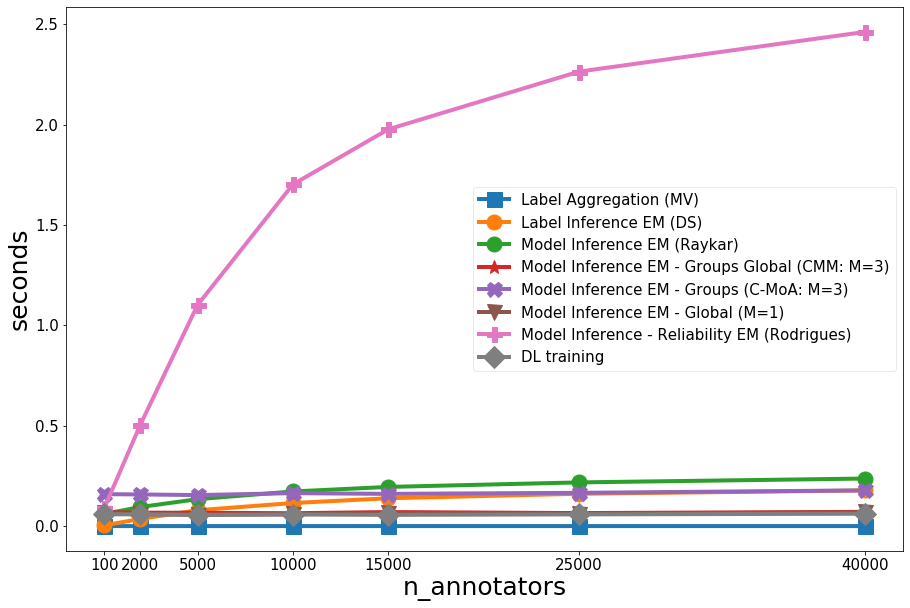

In [36]:
plt.figure(figsize=(15,10))
plt.plot(to_check, EXEC_hardmv, 's-', label="Label Aggregation (MV)", markersize=ms,linewidth=lw)
plt.plot(to_check, EXEC_ds, 'o-', label="Label Inference EM (DS)", markersize=ms,linewidth=lw)
plt.plot(to_check, EXEC_raykar, 'o-', label="Model Inference EM (Raykar)", markersize=ms,linewidth=lw)
plt.plot(to_check, EXEC_cmm, '*-', label="Model Inference EM - Groups Global (CMM: M=3)", markersize=ms,linewidth=lw)
plt.plot(to_check, EXEC_cmoa, 'X-', label="Model Inference EM - Groups (C-MoA: M=3)", markersize=ms,linewidth=lw)
plt.plot(to_check, EXEC_global, 'v-', label="Model Inference EM - Global (M=1)", markersize=ms,linewidth=lw)
plt.plot(to_check, EXEC_re, 'P-', label="Model Inference - Reliability EM (Rodrigues)", markersize=ms,linewidth=lw)
plt.plot(to_check, EXEC_DL_train, 'D-', label="DL training", markersize=ms,linewidth=lw)

plt.xticks(to_check)
plt.ylabel("seconds")
plt.xlabel("n_annotators")
plt.legend(loc='center right', fancybox=True, framealpha=0.4)
plt.show()

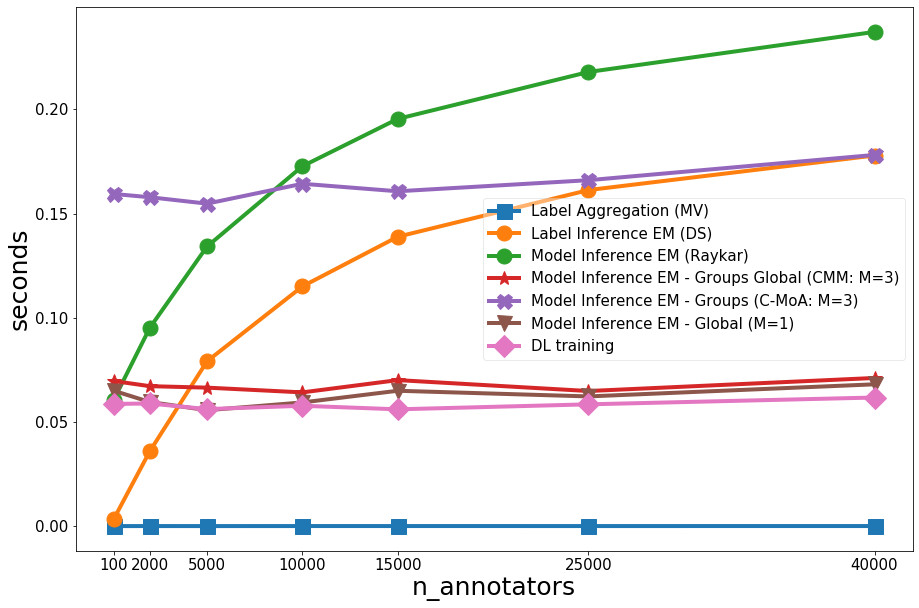

In [38]:
plt.figure(figsize=(15,10))
plt.plot(to_check, EXEC_hardmv, 's-', label="Label Aggregation (MV)", markersize=ms,linewidth=lw)
plt.plot(to_check, EXEC_ds, 'o-', label="Label Inference EM (DS)", markersize=ms,linewidth=lw)
plt.plot(to_check, EXEC_raykar, 'o-', label="Model Inference EM (Raykar)", markersize=ms,linewidth=lw)
plt.plot(to_check, EXEC_cmm, '*-', label="Model Inference EM - Groups Global (CMM: M=3)", markersize=ms,linewidth=lw)
plt.plot(to_check, EXEC_cmoa, 'X-', label="Model Inference EM - Groups (C-MoA: M=3)", markersize=ms,linewidth=lw)
plt.plot(to_check, EXEC_global, 'v-', label="Model Inference EM - Global (M=1)", markersize=ms,linewidth=lw)
plt.plot(to_check, EXEC_DL_train, 'D-', label="DL training", markersize=ms,linewidth=lw)

plt.xticks(to_check)
plt.ylabel("seconds")
plt.xlabel("n_annotators")
plt.legend(loc='center right', fancybox=True, framealpha=0.4)
plt.show()

The effect of increasing the number of groups modeled ($M$)is the same as the increase in the number of annotators (as are based on the confusion matrix).